# `Проект по оптимизации производственного процесса в металлургии`

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Содержание

- Подготовка материалов к анализу
    
- Исследовательский анализ данных 

- План работы по проекту

- Предобработка данных и формирование признаков

- Подбор гиперпараметров моделей и их обучение

- Тестирование полученных моделей

- Вывод по проекту

# Подготовка материалов к анализу

## Загрузка необходимых библиотек

In [1]:
# Первым делом самолеты... то есть, библиотеки!

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Модели регрессии

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Загрузка датасетов

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [2]:
# Для ускорения процесса и "облегчения" кода создадим список суффиксов названий датасетов

files = ['arc','bulk_time','bulk','gas','temp','wire_time','wire']

In [3]:
# С применением отобранных ранее суффиксов создадим цикл для записи датасетов в отдельные переменные, 
# который будет работать как локально, так и в тренажере Яндекса

try:
    for file in files:
        print('Создан датафрейм с именем df_'+file)
        exec("df_{} = pd.read_csv('data_'+file+'.csv')".format(file))
except:
    for file in files:
        print('Создан датафрейм с именем df_'+file)
        exec("df_{} = pd.read_csv('/datasets/final_steel/data_'+file+'.csv')".format(file))

Создан датафрейм с именем df_arc
Создан датафрейм с именем df_bulk_time
Создан датафрейм с именем df_bulk
Создан датафрейм с именем df_gas
Создан датафрейм с именем df_temp
Создан датафрейм с именем df_wire_time
Создан датафрейм с именем df_wire


# Исследовательский анализ данных

## Файл DF_ARK - данные о работе электродов

In [4]:
# Выведем датасет df_arc для визуального осмотра

df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
# Применим метод info для оценки структуры выборки

df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# Методом describe оценим статистические параметры датасета

df_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
# Во время последующего анализа у меня закрались сомнения в том, что максмимальный индекс партии соответствует
# реальному числу этих партий. Для проверки сделаем группировку по столбцу key

df_arc.groupby('key').count()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
key,,,,
1,5,5,5,5
2,4,4,4,4
3,5,5,5,5
4,4,4,4,4
5,4,4,4,4
...,...,...,...,...
3237,5,5,5,5
3238,3,3,3,3
3239,8,8,8,8


Действительно, количество партий в датасете - 3214, а не 3241. Будем учитывать это в дальнейшей работе

<AxesSubplot:>

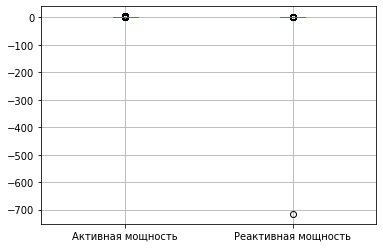

In [8]:
# Для оценки разброса данных построим график "ящик с усами"

df_arc.boxplot(['Активная мощность', 'Реактивная мощность'])

В значениях реактивной мощности наблюдается достаточно мощный выброс. Для оценки корреляции между мощностями сделаем срез, который органичит указанный выброс.

In [9]:
df_arc[df_arc['Реактивная мощность']>0][['Активная мощность', 'Реактивная мощность']].corr()

,Активная мощность,Реактивная мощность
Активная мощность,1.000000,0.963182
Реактивная мощность,0.963182,1.000000


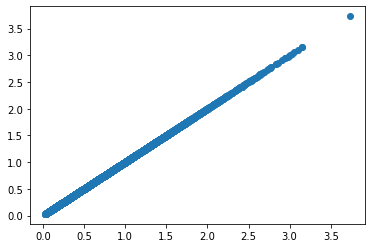

In [10]:
plt.scatter(df_arc['Активная мощность'], df_arc['Активная мощность'])

**Промежуточные выводы**

df_arc - содержит в себе данные о параметрах работы графитовых стержней. Состоит из 14876 строк (данные представлены за период с 3 мая по 1 сентября 2019 года) и 5 столбцов:

- key – номер партии, делит датасет на 3214 партий (хотя максимальный номер партии - 3241. Видимо, потеря в данных, хотя на качестве это сказаться не должно) по несколько замеров в каждой, формат данных int - корректировки не требует;
- время начала нагрева дугой, формат данных object - нужно перевести в datetime;
- время окончания нагрева дугой, формат данных object - нужно перевести в datetime;
- активная мощность, формат данных float - корректировки не требует;
- реактивная мощность, формат данных float - корректировки не требует. Содержит явный выброс - значение -715. Следует при очистке данных избавиться от него удалением/заменой на среднее(медиану) по партии.
    
Пропусков в датасете нет.
    
**Дополнительно:** между активной и реактивной мощностями наблюдается почти единичная положительная корреляция. Смысла отдавать данные признаки в модель нет. Лучше рассчитать полную мощность (корень от суммы квадратов активной и реактивной мощностей) и использовать ее в качестве признака.

## Файл DF_BULK_TIME - данные о подаче сыпучих материалов (время)

In [11]:
# Вызываем датасет df_bulk_time для визуального осмотра

df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [12]:
df_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [13]:
# Применим метод info для оценки структуры выборки

df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


**Промежуточные выводы**

df_bulk_time - содержит в себе данные о времени загрузки сыпучих материалов в сплав. Состоит из 3129 строк и 16 столбцов:

- key – номер партии, делит датасет на 3129 партий (еще меньше, чем в df_arc), формат данных int - корректировки не требует;
- 15 столбцов Bulk_ с суффиксом номера присадки. Каждый содержит отметку о времени добавления материала в сплав. В каждом столбце большое количество пропусков, которое означает, что материал не добавлялся. Формат данных object - нужно переводить в Datetime, если понадобиться работать с этими сведениями в дальнейшем.
    
Данный датасет можно использовать для проверки корректности обработки сплава - то есть, произведена ли была оценка температуры перед легированием, или же техпроцесс нарушен и действия перепутаны местами. 
    
Для данной работы датасет является избыточным.

## Файл DF_BULK - данные о подаче сыпучих материалов (объем)

In [14]:
# Вызываем датасет df_bulk для визуального осмотра

df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [15]:
# Применим метод info для оценки структуры выборки

df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
# Методом describe оценим статистические параметры датасета

df_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<AxesSubplot:>

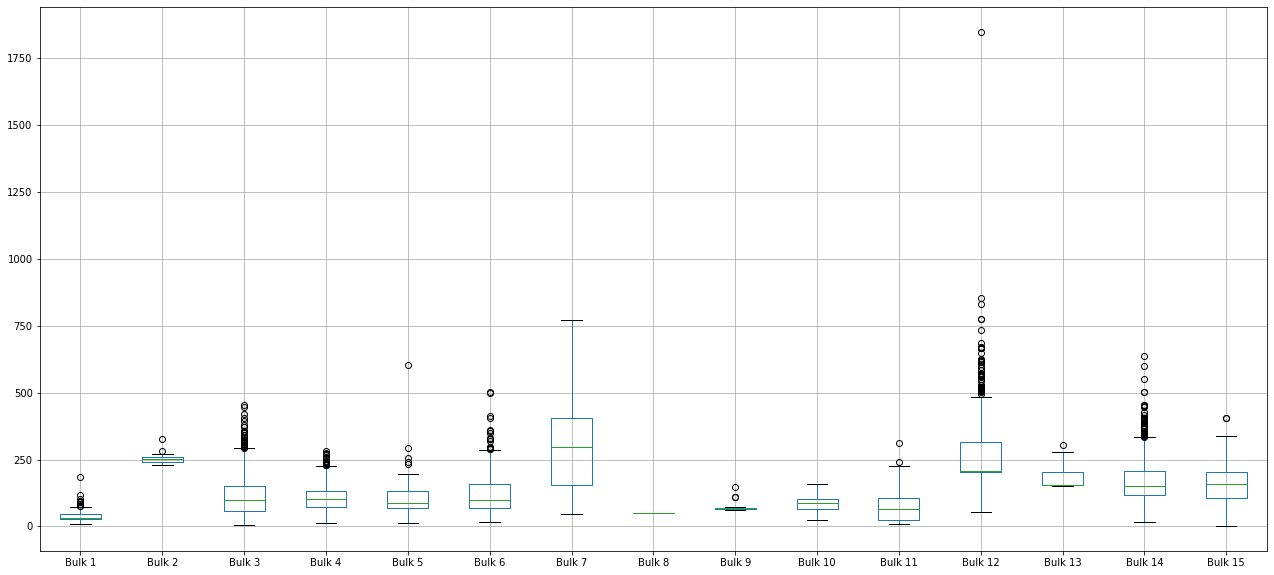

In [17]:
# Для оценки распределения данных построим "ящик с усами" для данного датасета

df_bulk.drop('key',axis=1).boxplot(figsize=(22,10))

**Промежуточные выводы**

Файл df_bulk - содержит в себе данные о количестве загруженных сыпучих материалов в сплав. Состоит из 3129 строк и 16 столбцов:

- key – номер партии (количество партий меньше, чем в df_arc, что говорит о заведомом уменьшении реального количества обучающих объектов), формат данных int - корректировки не требует;
- 15 столбцов Bulk_ с суффиксом номера присадки. Каждый содержит отметку о количестве добавленного материала в сплав. В каждом столбце большое количество пропусков, которое означает, что материал не добавлялся. Формат данных float - корректировки не требует.
    
**Дополнительно:** на графике boxplot в столбце bulk 12 отчетливо отображается выброс. Есть вероятность, что это часть производственного процесса, когда был сильный перекос по составу сплава, что пришлось корректировать добавлением в несколько раз больше среднего количетсво присадки, однако существует и вероятность ошибочного замера данного параметра. Следует проконсультироваться с тимлидом и инженерами. Пока можно оставить как есть.

Еще интересно, почему присадка №8 добавлялась лишь единожды за все процессы.
    
Из данного датасета можно "вытащить" полезные сведения о суммарном количестве присадок, добавленных в сплав за весь период работы с партией. Это послужит одним из обучающих признаков.

## Файл DF_GAS — данные о продувке сплава газом

In [18]:
# Вызываем датасет df_gas для визуального осмотра

df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
# Применим метод info для оценки структуры выборки

df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
# Методом describe оценим статистические параметры датасета

df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


array([[<AxesSubplot:title={'center':'Газ 1'}>]], dtype=object)

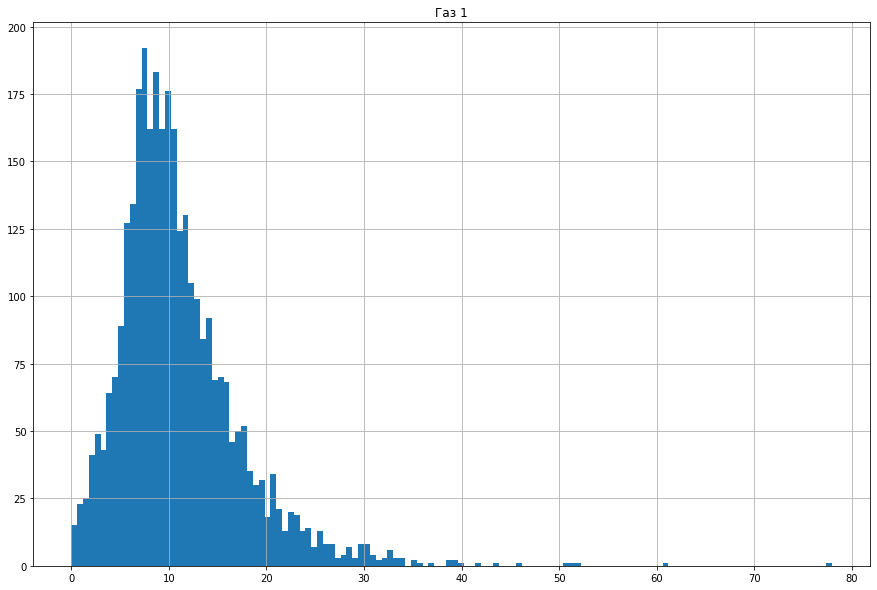

In [21]:
# Для оценки вида распределения данных построим гистограмму.

df_gas.hist(['Газ 1'], bins=130, figsize=(15,10))

<AxesSubplot:>

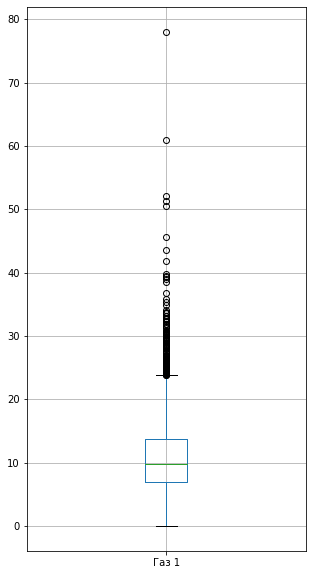

In [22]:
# Для оценки наличия выбросов построим "ящик с усами" для данного датасета

df_gas.boxplot(['Газ 1'], figsize=(5,10))

**Промежуточные выводы**

Файл df_gas - содержит в себе данные об объеме использования инертного газа при производстве. Состоит из 3239 строк и 2 столбцов:

- key – номер партии, формат данных int - корректировки не требует;
- Газ 1 - объем использованного инертного газа. Формат данных float - корректировки не требует. Распределение близкое к нормальному.
    
**Дополнительно:** на графике boxplot видно небольшое количество явных выбросов (после значения 40). Как представляется, от них можно без зазрения совести избавиться. Следует проконсультироваться с тимлидом. Пока оставим как есть, посмотрим на работу модели.
    
Из данного датасета можно забрать полезные сведения о количестве использованного газа. Это послужит одним из обучающих признаков.

## Файл DF_TEMP — результаты измерения температуры

In [23]:
# Вызываем датасет df_temp для визуального осмотра

df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [24]:
# Применим метод info для оценки структуры выборки

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [25]:
# Методом describe оценим статистические параметры датасета

df_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [26]:
# Как и в случае с df_arc, посчитаем реальное количество имеющихся данных о партиях в датасете

df_temp.groupby('key').count()

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
3237,5,1
3238,3,1
3239,8,1


И снова несоответствие данных по количеству партий в датасете и максимальным номером партии. Учтем это в дальнейшем.

<AxesSubplot:>

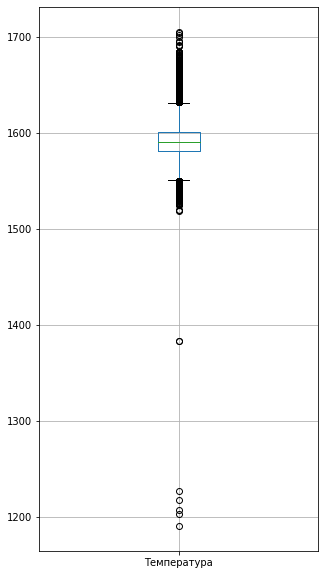

In [27]:
# Для оценки наличия выбросов построим "ящик с усами" для данного датасета

df_temp.boxplot('Температура', figsize=(5,10))

array([[<AxesSubplot:title={'center':'Температура'}>]], dtype=object)

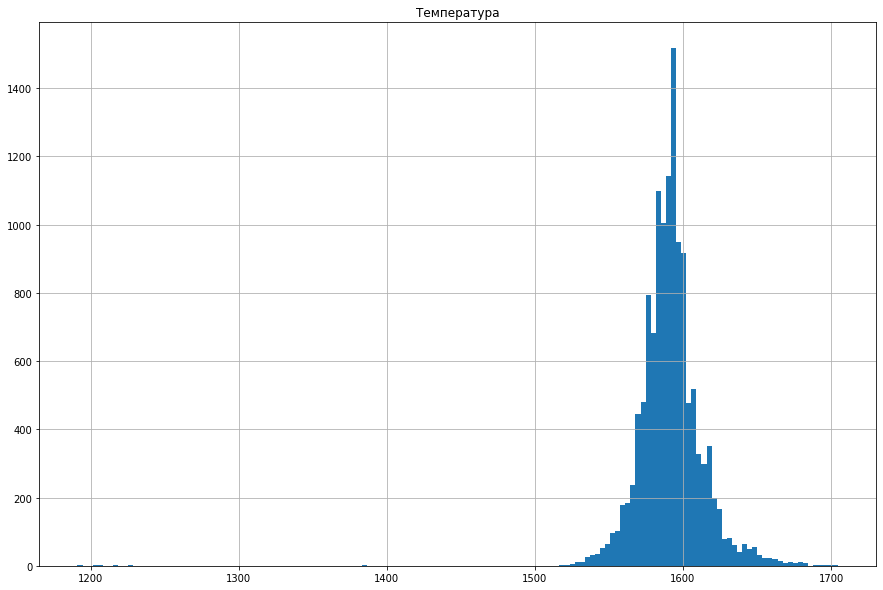

In [28]:
# Для оценки вида распределения построим гистограмму по столбцу "Температура"

df_temp.hist('Температура', bins=150, figsize=(15,10))

**Промежуточные выводы**

Файл df_temp - содержит в себе данные об замерах температуры сплава на различных этапах его производства. Состоит из 15907 строк и 3 столбцов:

- key – номер партии, делит датафрейм на 3216 партий (однако максимальный номер партии - 3241. Есть недостачи в данных) по несколько замеров. формат данных int - корректировки не требует;
- Время замера - тут все понятно. За одну партию замеров производится, как правило, более одного. Формат данных object - необходимо заменить на datetime.
- Температура - сами замеры температуры сплава. Распеделение нормальное, но имеются выбросы. формат данных float - корректировки не требует. Имеются пропуски.
    
**Дополнительно:** на графике boxplot видно небольшое количество явных выбросов (значения ниже 1500 градусов). Эти данные, скорее всего, вызваны технической ошибкой. Многие из них ниже 1300 градусов, что является нарушением техпроцесса (смесь может заливаться в ковш при температуре не ниже 1300 градусов). Следует проконсультироваться с тимлидом. Я бы эти данные удалил.
    
По поводу пропусков в температурном столбце - похоже на потерю данных, так как время замера присутствует.  Следует проконсультироваться с тимлидом. Если есть возможность получить недостающие показания, то очень хорошо. Если в данных о партии есть только один замер и меньше - придется удалять всю партию.
    
Из данного датасета можно забрать полезные сведения о начальной и конечной температуре (что станет целевым признаком). Для этого нужно будет произвести группировку по партиям и вытащить данные значения.

## Файл DF_WIRE_TIME — данные о проволочных материалах (время)

In [29]:
# Вызываем датасет df_wire_time для визуального осмотра

df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Применим метод info для оценки структуры выборки

df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


**Промежуточные выводы**

df_wire_time - содержит в себе данные о времени загрузки проволоки в сплав. Состоит из 3081 строки и 10 столбцов:

- key – номер партии, формат данных int - корректировки не требует;
- 9 столбцов Wire_ с суффиксом номера добавки. Каждый содержит отметку о времени добавления проволоки в сплав. В каждом столбце большое количество пропусков, которое означает, что материал не добавлялся. Формат данных object - нужно переводить в Datetime, если понадобиться работать с этими сведениями в дальнейшем.
    
Пока не предвидится полезности данного набора данных для текущего проекта (разве что, как и в случае с сыпучими материалами, для проверки адекватности данных по техпроцессу). Для данной работы датасет является лишним.

## Файл DF_WIRE — данные о проволочных материалах (объём)

In [31]:
# Вызываем датасет df_wire для визуального осмотра

df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Применим метод info для оценки структуры выборки

df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [33]:
# Методом describe оценим статистические параметры датасета

df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<AxesSubplot:>

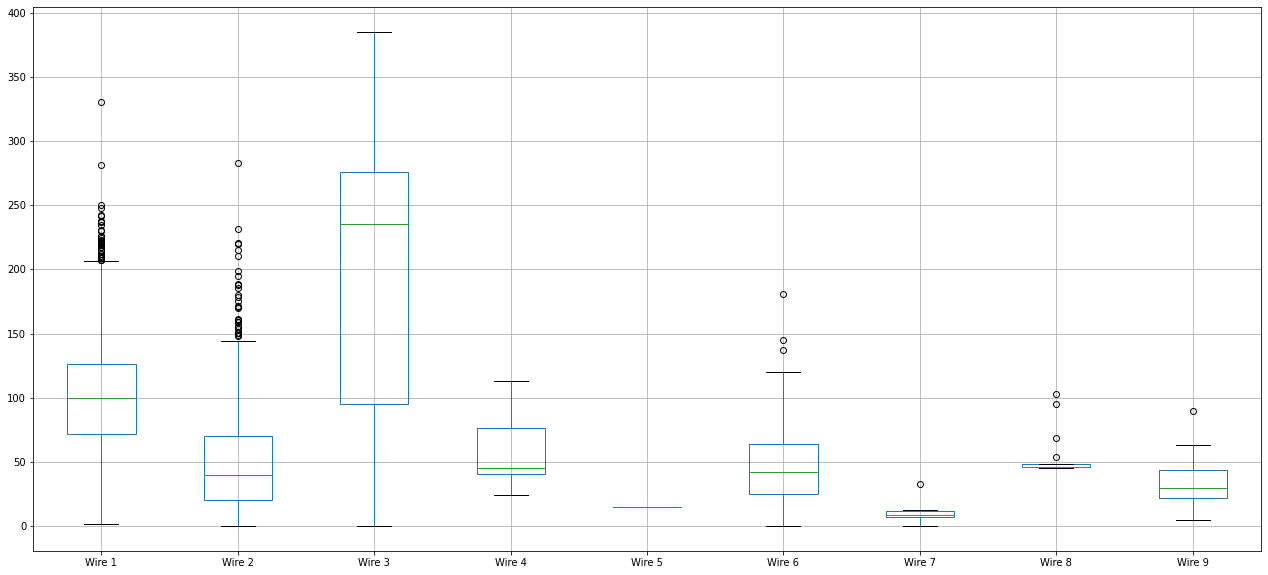

In [34]:
# Для оценки наличия выбросов построим "ящик с усами" для данного датасета

df_wire.drop('key', axis=1).boxplot(figsize=(22,10))

**Промежуточные выводы** 

Файл df_wire - содержит в себе данные о количестве добавленной в сплав проволоки. Состоит из 3081 строк и 10 столбцов:

1. key – номер партии (замеров 3081, а максимальный номер партии - 3241. Снова имеются недостачи в данных. Будем работать с тем, что есть), формат данных int - корректировки не требует;
2. 9 столбцов Wire_ с суффиксом номера присадки. Каждый содержит отметку о количестве добавленного материала в сплав. В каждом столбце большое количество пропусков, которое означает, что материал не добавлялся. Формат данных float - корректировки не требует.
    
**Дополнительно:** на графике boxplot в столбцах Wire 1,2,6,7,8,9 отчетливо отображаются немногочисленные выбросы. Есть вероятность, что это часть производственного процесса, когда был сильный перекос по составу сплава, что пришлось корректировать добавлением в несколько раз больше среднего количетсво присадки, однато существует и вероятность ошибочного замера данного параметра. Следует проконсультироваться с тимлидом по поводу целесообразности удаления данных объектов. Пока оставляем как есть
    
Проволоки №5 добавлялись лишь единожды. Почему?
    
Из данного датасета можно "вытащить" полезные сведения о суммарном количестве прооволоки, добавленной в сплав. Это послужит одним из обучающих признаков.

## Вывод по предварительному изучению датасета

На данном этапе работы была произведена оценка состава исходных файлов, изучен вопрос наличия пропусков в данных, выбросов, артефактов. Сделаны соответсвтующие предложения по их корректировке. 

Изучены типы данных в столбцах датасетов, высказаны мысли относительно необходимости их преобразования. 
    
Сделаны предположения о возможном использовании имеющихся данных и получении новых в качестве обучающих признаков и целевого признака.
    
Так, в дальнейшей работе целесообразно сосредоточиться на формировании следующих обучающих признаков:
    
- сумма Bulk;
- сумма Wire; 
- сумма Gas;
- полная мощность;
- время работы дуги; 
- температура начальная; 
- температура конечная (целевой признак); 
- время обработки партии;
- количество срабатываний дуги.

# Предварительный план работы с проектом

 Дальнейшую работу с проектом предполагаю строить в соответствии со следующим планом:

1. Преобразование данных - удаление (замена средним/медианой) выбросов, пропусков, дублей, артефактов. Изменение, где необходимо, типа данных.

2. Выбор признаков для обучения моделей - отобрать, рассчитать те параметры, которые могут подойти на эти роли (соответствущие предложения даны в разделе первичного изучения). Объединить их в одну таблицу по столбцу key

3. Отделение целевого признака (итоговая температура) от остальных, разделение выборки на обучающую и тестовую. 

4. Подбор, обучение и кросс-валидация моделей, снятие первичных метрик (предлагаю метрику RMSE). Сравнение с дамми-моделью.

5. Получение метрик на тестовых данных. Оформление выводов.

Вопросы к тимлиду:
    
- Какое значение метрики является целевым для заказчика?
    
- верна ли догадка, что в df_bulk и df_wire пропуск в данных является отметкой об отсутствии добавки?
    
- имеет ли смысл узнавать, какая добавка какой материал конкретно означает. Если да, то где эту информацию достать? (полагаю, что данная информация не важна для ML модели, но актуальна для исследователя с целью погружения в процесс производства и повышения вероятности достать инсайт оттуда, где сам не ожидал)
    
- Файл df_bulk, Bulk 12 в 303 строке одинокий выброс. Стоит ли его удалять? (думаю, что ничего не потеряем от его удаления)
    
- Есть ли вариант восстановить данные о замерах температуры, где стоят пропуски? Если нет - удаляем их? (полагаю, что надо удалять всю партию, так как нет данных о конечной температуре - целевого фактора).
    
На текущий момент выработано следующее предложение по составу обучающих признаков: 
    
- сумма Bulk, 
- сумма Wire, 
- сумма Gas, 
- общая активная мощность, 
- общая реактивная мощность, 
- полная мощность,
- время работы дуги, 
- температура начальная, 
- температура конечная (целевой признак), 
- количество срабатываний дуги.
        
Является ли такой состав достаточным? 

# Предобработка данных и формирование признаков

## Выявление партий с одним измерением температуры

In [35]:
# С помощью группировки выделим в датасете те партии, которым соответствует только одно измерение температуры

df_one = df_temp.groupby('key')['Температура'].count()==1

In [36]:
# Из полученного массива выбираем значения True (им соответствует 1 измерение температуры)

df_one = df_one[df_one==True]
len(df_one)

741

Итого, придется выкинуть аж 741 объект (23% данных). Жаль, но в данном случае это единственный вариант. Далее нужно беседовать с инженерами, чтобы обеспечили лучшую заполняемость сведений.

In [37]:
# В новый датасет запишем только те объекты, которые соответствуют отобранным значениям key.
# Для этого сделаем инедексом параметр key в исходном датасете 

df_temp_clean = df_temp.set_index(df_temp['key']).drop(df_one.index)
len(df_temp_clean.key.unique())

2475

## Удаление выбросов в датасете df_temp

In [38]:
# Технологический процесс требует разогрева сплава минимум до 1300 градусов. В нашем датасете есть выбросы ниже данной отметки. Их, а также один выброс на уровне 1400 градусов, удалим.

df_temp_clean = df_temp_clean[df_temp_clean['Температура']>1500]

<AxesSubplot:>

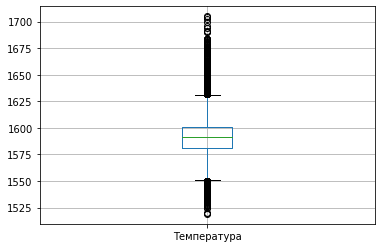

In [39]:
df_temp_clean.boxplot('Температура')

<AxesSubplot:xlabel='Температура'>

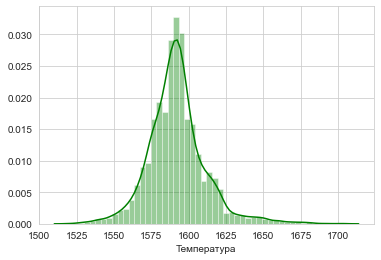

In [40]:
# Проверим вид распределения значений температур

sns.set_style('whitegrid')

plt.figure

sns.distplot(df_temp_clean['Температура'], color='green')

На графике вырисовывается близкое к нормальному распределение

## Обработка выброса в датасете df_arc

In [41]:
# Существующий выброс по реактивной мощности заменяем на среднее значение по его партии

df_arc[df_arc['Реактивная мощность']<0] = df_arc[(df_arc['key']==2116)&(df_arc['Реактивная мощность']>0)]['Реактивная мощность'].mean()

<AxesSubplot:>

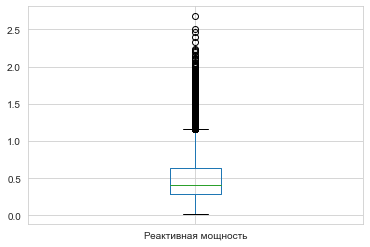

In [42]:
df_arc.boxplot(['Реактивная мощность'])

## Формирование признаков

### Создание признака "время обработки партии"

In [43]:
# Для формирования признака "время обработки партии" рассчитаем разницу между последним и первым замерами температуры для каждой партии
# Для этого сначала найдем эти значения

time_first = pd.DataFrame(df_temp.groupby('key')['Время замера'].min())
time_last = pd.DataFrame(df_temp.groupby('key')['Время замера'].max())

time_temp = time_first.join(time_last, lsuffix='_первое', rsuffix='_последнее').reset_index()

time_temp['Время замера_первое'] = pd.to_datetime(time_temp['Время замера_первое'])
time_temp['Время замера_последнее'] = pd.to_datetime(time_temp['Время замера_последнее'])
time_temp

,key,Время замера_первое,Время замера_последнее
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16


In [44]:
# Теперь рассчитаем саму разницу между найденными показателями и переведем реультат в секунды

time_temp['batch_time'] = pd.to_datetime(time_temp['Время замера_последнее']) - pd.to_datetime(time_temp['Время замера_первое'])
time_temp['batch_time_min'] = time_temp['batch_time'].dt.total_seconds()/60
time_temp

,key,Время замера_первое,Время замера_последнее,batch_time,batch_time_min
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,0 days 00:14:21,14.350000
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,0 days 00:21:45,21.750000
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,0 days 00:21:40,21.666667
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,0 days 00:06:28,6.466667
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,0 days 00:12:42,12.700000
...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,0 days 00:21:39,21.650000
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,0 days 00:12:29,12.483333
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,0 days 00:52:28,52.466667
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,0 days 00:56:15,56.250000


In [45]:
# Искомый признак вместе со значением "key" сохраняем в отдельный датафрейм

heating_time_min = time_temp[['key', 'batch_time_min']]
heating_time_min

,key,batch_time_min
0,1,14.350000
1,2,21.750000
2,3,21.666667
3,4,6.466667
4,5,12.700000
...,...,...
3211,3237,21.650000
3212,3238,12.483333
3213,3239,52.466667
3214,3240,56.250000


### Добавление признака "полная мощность"

In [46]:
df_arc['power_full'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**0.5

<AxesSubplot:>

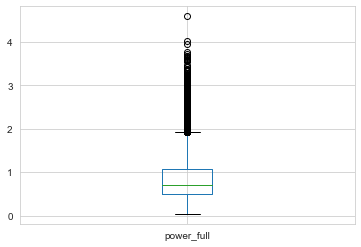

In [47]:
df_arc.boxplot('power_full')

In [48]:
# Искомый признак вместе со значением "key" сохраняем в отдельный датафрейм

df_power_sum = df_arc[['key','power_full']].groupby('key').sum()
df_power_sum

,power_full
key,
0.304429,0.430528
1.000000,5.826395
2.000000,3.649216
3.000000,2.989534
4.000000,3.814962
...,...
3237.000000,4.844982
3238.000000,2.696542
3239.000000,5.611883


### Создание признака "время работы дуги"

In [49]:
# Для дальнейшей обработки переведем столбцы со временем в датасетах в формат datetime

df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])

In [50]:
# Сделаем расчет общего времени работы дуги для каждого этапа

df_arc['heating_time_min'] = (df_arc['Конец нагрева дугой']-df_arc['Начало нагрева дугой']).dt.total_seconds()/60

In [51]:
# Искомый признак вместе со значением "key" сохраняем в отдельный датафрейм

df_arc_grouped = df_arc.groupby('key')['heating_time_min'].sum()
df_arc_grouped

key
0.304429        0.000000
1.000000       18.300000
2.000000       13.516667
3.000000       10.916667
4.000000       12.350000
                 ...    
3237.000000    15.150000
3238.000000     9.100000
3239.000000    20.266667
3240.000000    13.983333
3241.000000    10.983333
Name: heating_time_min, Length: 3215, dtype: float64

### Расчет суммарного количества сыпучих добавок, проволоки и газа

In [52]:
df_bulk['bulk_sum'] = df_bulk.fillna(0).drop('key', axis=1).sum(axis=1)
df_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_sum
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,758.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,594.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,630.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,272.0


In [53]:
df_wire['sum_wire'] = df_wire.fillna(0).drop('key', axis=1).sum(axis=1)
df_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796
...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.088959
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.128799
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.357761
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.070400


In [54]:
df_gas['gas_sum'] = df_gas.fillna(0).drop('key', axis=1).sum(axis=1)
df_gas

,key,Газ 1,gas_sum
0,1,29.749986,29.749986
1,2,12.555561,12.555561
2,3,28.554793,28.554793
3,4,18.841219,18.841219
4,5,5.413692,5.413692
...,...,...,...
3234,3237,5.543905,5.543905
3235,3238,6.745669,6.745669
3236,3239,16.023518,16.023518
3237,3240,11.863103,11.863103


### Извлечение стартовой и конечной температуры

In [55]:
# Выделим с помощью цикла первые и последние значения замеров температур по партиям

keys = df_temp_clean['key'].unique()
temp_start_end = pd.DataFrame(columns=['key','temp_start', 'temp_end'])

i = 0
for key in keys:
    
    batch = df_temp_clean.query('key == @key')
    start = list(batch['Температура'])[0]
    end = list(batch['Температура'])[-1]
    
    temp_start_end.loc[i, 'key'] = key
    temp_start_end.loc[i, 'temp_start'] = start
    temp_start_end.loc[i, 'temp_end'] = end
    
    i += 1

### Создание признака "количество срабатываний электродов"

In [56]:
# В качестве дополнительного признака для обучения подсчитаем число срабатываний электродов по партиям

df_electrodes = df_arc.groupby('key').count()

df_electrodes['electrodes_run'] = df_electrodes['Начало нагрева дугой']

df_electrodes = df_electrodes['electrodes_run']

### Объедиенение признаков в одну таблицу

In [57]:
df_merged = temp_start_end.merge(df_power_sum, on = "key", how = 'outer').dropna()

In [58]:
df_merged = df_merged.merge(df_wire[['key', 'sum_wire']], on = "key", how = 'outer').dropna()

In [59]:
df_merged = df_merged.merge(df_gas[['key', 'gas_sum']], on = "key", how = 'outer').dropna()

In [60]:
df_merged = df_merged.merge(df_bulk[['key', 'bulk_sum']], on = "key", how = 'outer').dropna()

In [61]:
df_merged = df_merged.merge(df_electrodes, on = "key", how = 'outer').dropna()

df_merged = df_merged.merge(df_arc_grouped, on = "key", how = 'outer').dropna()

In [62]:
df_merged = df_merged.merge(heating_time_min, on = "key", how = 'outer').dropna()

In [63]:
df_merged['temp_start'] = df_merged['temp_start'].astype('float')
df_merged['temp_end'] = df_merged['temp_end'].astype('float')

In [64]:
df_merged

,key,temp_start,temp_end,power_full,sum_wire,gas_sum,bulk_sum,electrodes_run,batch_time_min
0,1.0,1571.0,1613.0,5.826395,60.059998,29.749986,553.0,5.0,14.350000
1,2.0,1581.0,1602.0,3.649216,96.052315,12.555561,582.0,4.0,21.750000
2,3.0,1596.0,1599.0,2.989534,91.160157,28.554793,544.0,5.0,21.666667
3,4.0,1601.0,1625.0,3.814962,89.063515,18.841219,595.0,4.0,6.466667
4,5.0,1576.0,1602.0,4.035758,98.352796,5.413692,584.0,4.0,12.700000
...,...,...,...,...,...,...,...,...,...
2324,2495.0,1570.0,1591.0,3.986869,89.150879,7.125735,719.0,4.0,18.950000
2325,2496.0,1554.0,1591.0,5.057033,114.179527,9.412616,796.0,6.0,26.966667
2326,2497.0,1571.0,1589.0,2.885017,103.134723,6.271699,665.0,3.0,11.950000
2327,2498.0,1591.0,1594.0,4.143749,118.110717,14.953657,733.0,5.0,21.700000


Итого, после всех обработок мы получили 2329 строк для исследования. Потеряли около 25%. Но могло быть и хуже.

<AxesSubplot:>

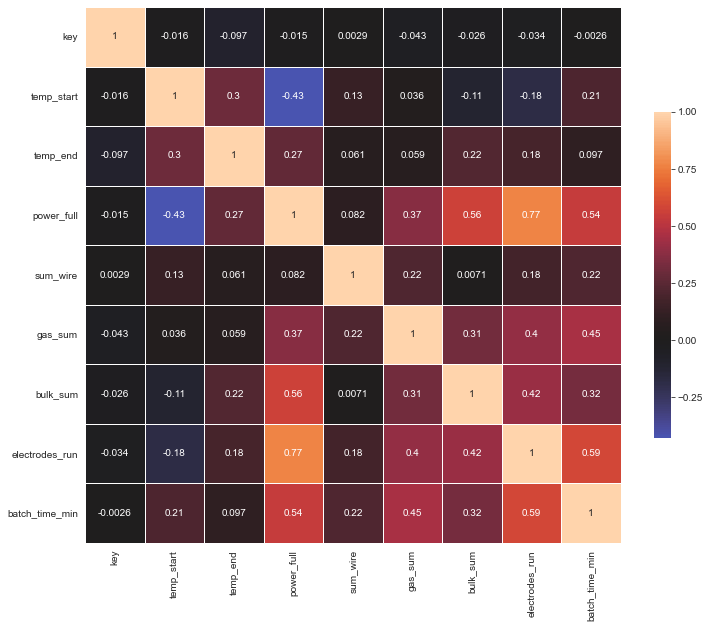

In [65]:
# Проверим корреляцию между имеющимися фичами

plt.figure(figsize=(12,12))
sns.heatmap(df_merged.corr(), center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Сильная корреляция наблюдается между признаками power_full (полная мощность) и electrodes_run (количество срабатываний электродов). Посмотрим на поведение моделей. Ранее использовался также признак "время работы дуги", но он имел слишком высокий коэффициент корреляции с полной мощностью, в связи с чем было принято решение его не использовать.

### Разбиение датасета на обучающую и тестовую выборки

In [66]:
df_train, df_test = train_test_split(df_merged, random_state =1234, test_size = 0.25)

In [67]:
df_train.shape

(1746, 9)

In [68]:
df_test.shape

(583, 9)

In [69]:
df_train_features = df_train.drop('temp_end', axis=1)
df_train_features.head()

,key,temp_start,power_full,sum_wire,gas_sum,bulk_sum,electrodes_run,batch_time_min
1858,1987.0,1574.0,1.438105,98.061600,3.055575,92.0,2.0,5.850000
769,836.0,1587.0,2.279040,89.013596,12.147076,451.0,3.0,28.183333
1320,1417.0,1559.0,4.501239,148.209358,8.855217,987.0,4.0,12.633333
1931,2065.0,1612.0,3.490722,140.081757,8.709560,744.0,5.0,33.333333
580,628.0,1585.0,5.616946,157.308320,15.969264,741.0,4.0,32.583333


<AxesSubplot:>

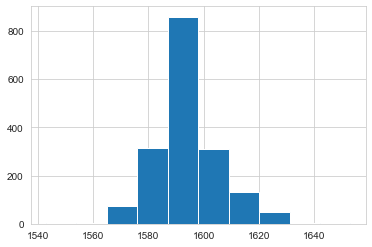

In [70]:
df_train_target = df_train['temp_end']
df_train_target.hist()

<AxesSubplot:>

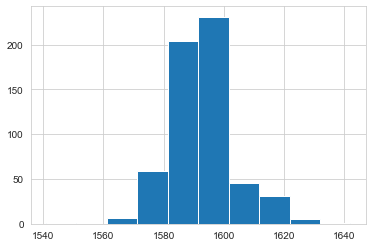

In [71]:
df_test_features = df_test.drop('temp_end', axis=1)
df_test_target = df_test['temp_end']
df_test_target.hist()

In [72]:
# Проверка схожести распределений тренировочной и тестовой выборки с помощью критерия Колмогорова-Смирнова. 
# Данный тест ставит нулевую гипотезу о равенстве двух распределений.
# Выберем статистическую значимость P_value на уровне 0,05

from scipy.stats import ks_2samp
ks_2samp(df_train_target, df_test_target)

KstestResult(statistic=0.06246279169834898, pvalue=0.06263645393883532)

pvalue=0.06263645393883532 - выше установленного нами значения. Значит, мы не можем отвергнуть гипотезу о равенстве распределений тестовой и тренировочной выборок. Можно работать дальше.

## Вывод по разделу

Итак, в данном разделе были осуществлены следующие действия:
    
- выявление и удаление из датасета информации о партиях, в отношении которых было произведено только одно измерение температуры;
- удаление значений ниже 1500 градусов в датасете df_temp;
- замена выброса в реактивной мощности на среднее значение по партии;
- формирование 9 обучающих признаков и объединение их в одну таблицу;
- разбиение датасета на обучающую и тестовую выборку, отделение целевого признака, проверка "законности" разбиения сравнением их распределения критерием Колмогорова-Смирнова;
- оценка корреляции признаков между собой.

# Подбор гиперпараметров моделей и их обучение

## Создание функций для автоматизации процесса и уменьшения кода

In [73]:
# Функция для поиска оптимальных гиперпараметров модели

def grid_search(model, parameters, features, target):
      
    g_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    g_search.fit(features, target)
    print(g_search.best_score_)
    print(g_search.best_params_)
    return g_search.best_params_

In [74]:
# Функция для кросс-валидации

def cross_val(model, features, target):
    
    metric_score = cross_val_score(model, features, target, cv=5, scoring='neg_mean_absolute_error')
    
    print('Результаты метрики при CV:', metric_score)
    print('Среднее значение метрики при CV:', abs(metric_score.mean()))
    return abs(metric_score)

In [75]:
# Функция для расчета MAE на тренировочной выборке

def mae_train(model, features_train, target_train): 
    
    mae_train = mean_absolute_error(target_train, model.predict(features_train)) 
    print('MAE модели на тренировочной выборке:', mae_train)
    return abs(mae_train)

In [76]:
# Функция для расчета MAE на тестовой выборке

def mae_test(model, features_test, target_test):
    
    mae_test = mean_absolute_error(target_test, model.predict(features_test))
    print('MAE модели на тестовой выборке:', mae_test)
    return mae_test

## Проверка на дамми-модели (на адекватность)

In [77]:
# Для начала проверим значение метрики на тренировочных данных для дамми-модели, которая предсказывает средним значением

dummy = DummyRegressor(strategy="mean")
dummy.fit(df_train_features, df_train_target)

mae_train_dummy = mae_train(dummy, df_train_features, df_train_target)

MAE модели на тренировочной выборке: 8.315411170549863


In [78]:
CV_train_dummy = cross_val(dummy, df_train_features, df_train_target).mean()

Результаты метрики при CV: [-8.07554237 -8.65395762 -7.77029984 -8.90524107 -8.22927764]
Среднее значение метрики при CV: 8.3268637080042


## Линейная регрессия

In [79]:
# Далее переходим к линейной регрессии

linear_regression = LinearRegression()
linear_regression.fit(df_train_features, df_train_target)

LinearRegression()

In [80]:
# Здесь уже можно проводить кросс-валидацию

CV_train_LR = cross_val(linear_regression, df_train_features, df_train_target).mean()

Результаты метрики при CV: [-5.89495383 -5.91633962 -6.34101906 -6.7615721  -6.3991134 ]
Среднее значение метрики при CV: 6.262599601318838


In [81]:
# Применяем функцию для расчета MAE

mae_train_LR = mae_train(linear_regression, df_train_features, df_train_target)

MAE модели на тренировочной выборке: 6.184777624267106


In [82]:
# Оценим значимость признаков для модели

LR_features_inportance = pd.DataFrame(data = [], columns=['feature', 'importance'])
LR_features_inportance['feature'] = pd.Series(df_train_features.columns)
LR_features_inportance['importance'] = pd.Series(linear_regression.coef_)
LR_features_inportance.sort_values(by='importance', ascending=False)

,feature,importance
2,power_full,7.224403
1,temp_start,0.423754
3,sum_wire,0.003898
0,key,-0.001313
5,bulk_sum,-0.001409
4,gas_sum,-0.105421
7,batch_time_min,-0.310090
6,electrodes_run,-1.043498


<AxesSubplot:xlabel='feature', ylabel='importance'>

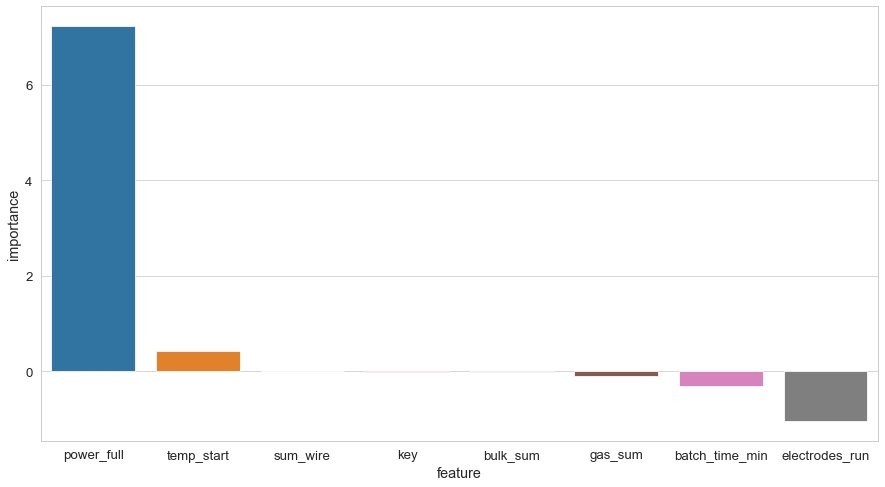

In [83]:
# Результат также выведем на гистограмме

plt.figure(figsize=(15,8))
sns.set_context("paper", font_scale=1.5)   
sns.barplot(data=LR_features_inportance.sort_values(by='importance', ascending=False), x="feature", y="importance")

## Случайный лес

In [84]:
# Переходим к ансамблевой модели случайного леса

model_forest = RandomForestRegressor(random_state=1234, n_jobs=-1)

model_forest_params = dict(n_estimators=[100,200,300,400,500],
                  max_depth=[3,5,7,9],
                  criterion=['mae'])

params_best_RF = grid_search(model_forest, model_forest_params, df_train_features, df_train_target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
-6.4155346573884575
{'criterion': 'mae', 'max_depth': 9, 'n_estimators': 500}


In [85]:
# Формируем модель с подобранными гиперпараметрами

model_forest = RandomForestRegressor(n_estimators=params_best_RF['n_estimators'], 
                                     max_depth=params_best_RF['max_depth'], 
                                     criterion='mae', 
                                     random_state=1234, 
                                     n_jobs=-1)

In [86]:
# Обучаем случайный лес на тренировочных данных

model_forest.fit(df_train_features, df_train_target)

RandomForestRegressor(criterion='mae', max_depth=9, n_estimators=500, n_jobs=-1,
                      random_state=1234)

In [87]:
# Проводим кросс-валидацию

CV_train_RF = cross_val(model_forest, df_train_features, df_train_target).mean()

Результаты метрики при CV: [-6.17802286 -6.46942407 -6.25875931 -6.98078797 -6.19067908]
Среднее значение метрики при CV: 6.4155346573884575


In [88]:
# Применяем функцию для расчета MAE

mae_train_RF = mae_train(model_forest, df_train_features, df_train_target)

MAE модели на тренировочной выборке: 4.40973424971363


In [89]:
# Оценим значимость признаков для модели и выведем список по убыванию

RF_features_inportance = pd.DataFrame(data = [], columns=['feature', 'importance'])
RF_features_inportance['feature'] = pd.Series(df_train_features.columns)
RF_features_inportance['importance'] = pd.Series(model_forest.feature_importances_)
RF_features_inportance.sort_values(by='importance', ascending=False)

,feature,importance
1,temp_start,0.253514
2,power_full,0.242273
7,batch_time_min,0.128445
3,sum_wire,0.098418
5,bulk_sum,0.088495
4,gas_sum,0.083242
0,key,0.081188
6,electrodes_run,0.024425


<AxesSubplot:xlabel='feature', ylabel='importance'>

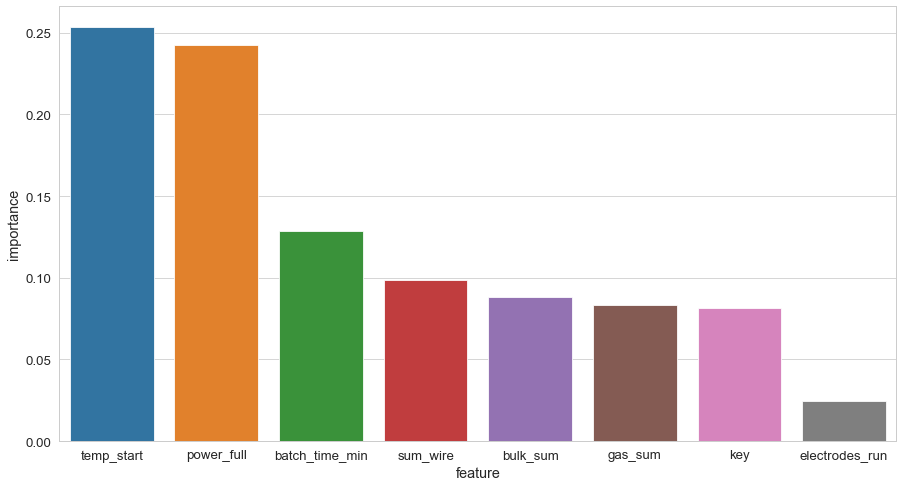

In [90]:
# Результат также выведем на гистограмме

plt.figure(figsize=(15,8))
sns.set_context("paper", font_scale=1.5)   
sns.barplot(data=RF_features_inportance.sort_values(by='importance', ascending=False), x="feature", y="importance")

## Градиентный бустинг

In [91]:


model_GBR = GradientBoostingRegressor(random_state=1234, learning_rate=0.02)

GBR_params = dict(n_estimators=[100,300,500,600,700,800,900,1000],
                   max_depth=[4,5,6,7,8,9,10],
                    subsample=[0.9, 0.8, 0.7, 0.6])

In [92]:
params_best_GBR = grid_search(model_GBR, GBR_params, df_train_features, df_train_target)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
-6.039136941649604
{'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.6}


In [93]:
model_GBR = GradientBoostingRegressor(n_estimators=params_best_GBR['n_estimators'], 
                                      learning_rate=0.02, 
                                      max_depth=params_best_GBR['max_depth'], 
                                      subsample=params_best_GBR['subsample'], 
                                      random_state=1234)

In [94]:
%%time
model_GBR.fit(df_train_features, df_train_target)

Wall time: 2.08 s


GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=1000,
                          random_state=1234, subsample=0.6)

In [95]:
CV_train_GBR = cross_val(model_GBR, df_train_features, df_train_target).mean()

Результаты метрики при CV: [-5.79604862 -6.02472963 -5.83457908 -6.48235172 -6.05797566]
Среднее значение метрики при CV: 6.039136941649604


In [96]:
%%time
mae_train_GBR = mae_train(model_GBR, df_train_features, df_train_target)

MAE модели на тренировочной выборке: 3.1938798883688904
Wall time: 27 ms


In [97]:
# Оценим значимость признаков для модели и выведем список по убыванию

GBR_features_inportance = pd.DataFrame(data = [], columns=['feature', 'importance'])
GBR_features_inportance['feature'] = pd.Series(df_train_features.columns)
GBR_features_inportance['importance'] = pd.Series(model_GBR.feature_importances_)
GBR_features_inportance.sort_values(by='importance', ascending=False)

,feature,importance
2,power_full,0.262096
1,temp_start,0.249451
7,batch_time_min,0.159963
0,key,0.086789
3,sum_wire,0.079925
5,bulk_sum,0.075394
4,gas_sum,0.063475
6,electrodes_run,0.022907


<AxesSubplot:xlabel='feature', ylabel='importance'>

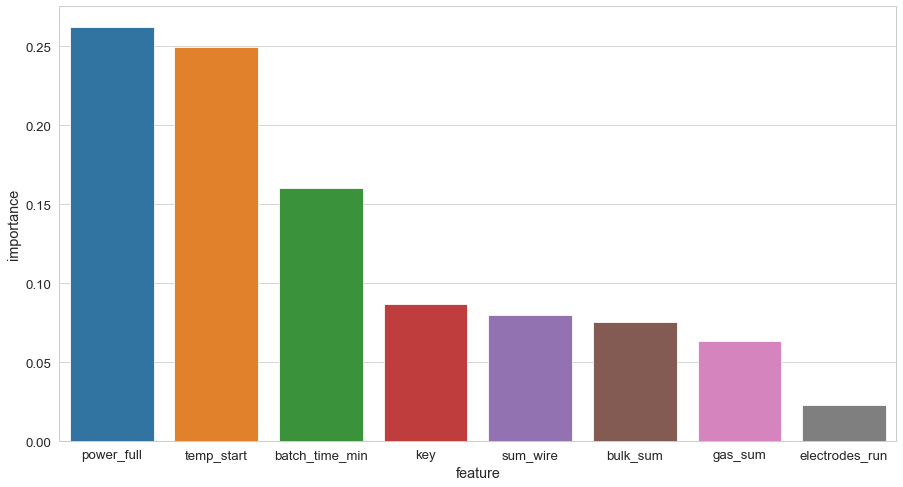

In [98]:
# Результат также выведем на гистограмме

plt.figure(figsize=(15,8))
sns.set_context("paper", font_scale=1.5)   
sns.barplot(data=GBR_features_inportance.sort_values(by='importance', ascending=False), x="feature", y="importance")

Итак, наибольший вклад в результирующий показатель вносят полная мощность и стартовая температура. Таким образом, если найти способы корректировки данных параметров на производстве, можно обеспечить экономию бюджета. Таблица корреляции выше показывает отрицательную зависимость между данными признаками (-0,43), что говорит о том, что, повышая один признак, можно уменьшить другой. То есть, если получится подгонять стартовую температуру к требуемым параметрам, то придется меньше электроэнергии тратить на нагрев дугой.

# Тестирование полученных моделей

## Дамми-модель

In [99]:
%%time
mae_test_dummy = mae_test(dummy, df_test_features, df_test_target)
mae_test_dummy

MAE модели на тестовой выборке: 7.46492841270121
Wall time: 0 ns


7.46492841270121

## Линейная регрессия

In [100]:
%%time
mae_test_LR = mae_test(linear_regression, df_test_features, df_test_target)
mae_test_LR

MAE модели на тестовой выборке: 6.064491822027357
Wall time: 1 ms


6.064491822027357

## Случайный лес

In [101]:
%%time
mae_test_RF = mae_test(model_forest, df_test_features, df_test_target)
mae_test_RF

MAE модели на тестовой выборке: 5.773475128644943
Wall time: 52 ms


5.773475128644943

## Градиентный спуск

In [102]:
%%time
mae_test_GBR = mae_test(model_GBR, df_test_features, df_test_target)
mae_test_GBR

MAE модели на тестовой выборке: 5.644597556922192
Wall time: 11 ms


5.644597556922192

## Итоговая таблица

In [103]:
table_final = pd.DataFrame({'Модель': ['Dummy_mean', 'Линейная регрессия', 'Случайный лес', 'Градиентный бустинг'],
                            'MAE_CV_train': [CV_train_dummy, CV_train_LR, CV_train_RF, CV_train_GBR],
                            'MAE_train': [mae_train_dummy, mae_train_LR,mae_train_RF, mae_train_GBR],
                           'MAE_test': [mae_test_dummy, mae_test_LR,mae_test_RF, mae_test_GBR]})

In [104]:
table_final

,Модель,MAE_CV_train,MAE_train,MAE_test
0,Dummy_mean,8.326864,8.315411,7.464928
1,Линейная регрессия,6.262600,6.184778,6.064492
2,Случайный лес,6.415535,4.409734,5.773475
3,Градиентный бустинг,6.039137,3.193880,5.644598


## Вывод по разделу

В данном разделе были подобраны гиперпараметры для моделей случайного леса и градиентного бустинга, обучены эти, а также модель линейной регрессии и дамми-модель на тренировочных данных, произведена кросс-валидация результатов. Полученные модели задействовались для выдачи предсказаний целевого признака (финальная температура сплава).
    
Для линейной регрессии самым значимым параметром оказалась полная мощность. У случайного леса и градиентного бустинга картины практически идентичные, более всего внимания они уделили стартовой температуре и полной мощности.
    
По итогу лучший результат показала модель градиентного бустинга (MAE = 5,64). На втором месте случайный лес с показателем 5.77. В конце линейная регрессия - 6.06. Все модели прошли проверку на адекватность (их показатели лучше, чем у дамми-модели).

# Вывод по проекту

В ходе препроцессинга в данной работе были проведены следующие процедуры:
    
- изучение каждого датасета на предмет его качественного состава, изучения взаимозависиместей признаков и их распределений, пригодности для дальнейшей работы;
- поиск пропусков/дублей/выбросов/артефактов, выработка решений по их нейтрализации/замене, их обработка;
- формирование мнения о возможностях получения обучающих признаков из имеющихся датасетов, расчет и сбор этих признаков, аккумулирование данных в одном датасете.
    
По результатам проведения предобработки объектов были сделаны следующие выводы:
- качественный состав датасетов при внесении незначительных корректив пригоден для обучения на нем моделей машинного обучения и получения на данной основе предсказаний целевого признака - финальной температуры слава;
- порядка 25% партий оказались непригодными для анализа в связи с наличием только одного замера температуры (т.е. нет целевого признака). В связи с этим информация об этих партиях была отброшена. Конечно, это в определенной мере повлияет на размер итоговой метрики, но некритично. В будущем полагаю целесообразным ориентировать инженеров на производстве на повышение качества сбора данных, чтобы не допускать появления таких пропусков.
- большинство признаков в датасетах имеет невысокий процент выбросов, появление которых может быть оправдано частью производственного процесса, наличием человеческого фактора, разницей количественного состава сплавов и т.д. В данной работе было принято решение сначала отработать только те единичные выбросы, которые никоим образом не могли быть классифицированы как допустимые (например, отрицательное значение реактивной мощности и т.п.). В дальнейшем, если целевая метрика не соответствует требуемым параметрам, предполагалось приступить к обработке других выбросов, загоняя данные в определенные "рамки", то есть создавая для модели граничные условия по признакам. С учетом того, что изначальной обработки выбросов хватило (MAE<6), такие граничные условия на данном этапе было решено не вводить. 

В итоговом составе обучающих признаков по итогу работы было решено оставить 8 элементов: 
- power_full (полная мощность) - рассчитывается как корень суммы квадратов активной и реактивной мощностей. Последние признаки было решено отбросить, так как их корреляция между собой составила 0.96 - практически прямая зависимость, что только излишне загрузило бы ресурсы системы при обработке, а в случае с линейными моделями и вовсе недопустимо;
- temp_start (начальная температура сплава);
- batch_time_min (время обработки партии в минутах) - получено путем расчета разницы между первым и последним замерами температуры сплава;
- key (номер партии);
- sum_wire (суммарное количество добавленной проволоки в партии);
- bulk_sum (суммарное количество добавленных сыпучих материалов);
- gas_sum (суммарных объем использованного в партии инертного газа);
- electrodes_run (число запуска электродов за время обработки партии).
   
Кроме того, в ходе работы был рассчитан признак общего времени работы дуги, но в связи с его высоким показателем корреляции с полной мощностью было принято решение отказаться от его использования в моделировании.

Таким образом, данные были подготовлены для передачи в модели машинного обучения. По итогам обучения и тестирования трех моделей (линейная регрессия - MAE = 6.064, случайный лес - MAE = 5.773 и градиентный бустинг - MAE = 5.645) 

С задачей справился лучше всего именно градиентный бустинг, который и был рекомендован для использования в производстве.
    
    
**Выводы по анализу показателя feature importance для выбранной модели градиентного бустинга:**
    
Наибольший вклад в результирующий показатель вносят полная мощность (0,26) и стартовая температура сплава (0,25). 
    
При этом показатель целевой мощности напрямую воздействует на затраты электроэнергии, что нам и нужно снижать. Таблица корреляции выше показывает отрицательную зависимость между данными признаками (-0,43). Это означает, что при повышении стартовой температуры с высокой вероятностью будет уменьшаться необходимое количество выделяемой мощности для нагрева при неизменных остальных условиях. То есть, если в ковш изначально подавать состав более высокой температуры, то придется меньше электроэнергии тратить на нагрев сплава дугой.
    
Как вариант, в дальнейшем можно было бы исследовать зависимость целевого признака от температуры подаваемых в сплав присадок. Данный параметр, теоретически, мог бы уменьшить необходимость использования дополнительного применения дуги.